## Installing and Importing Packages, and Mounting Google Drive

In [ ]:
# useful installations
!pip install sacremoses

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 13.6 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import re
import os
import sys
import math

import string
from collections import defaultdict

from google.colab import data_table

from sacremoses import MosesPunctNormalizer

In [ ]:
# mounting google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Load Data

This involves reading the data from text files into lists, and converting the lists into a `pandas.DataFrame` for further processing.

When reading text files, we ensure that characters in the files are encoded as `utf-8` characters.

In [ ]:
# define source and target languages
source_name = 'English'
target_name = 'IsiNdebele'

source_code = 'eng'
target_code = 'nde'

In [ ]:
# loading data
main_path = f'/content/drive/My Drive/Research/{source_code}-to-{target_code}'
source_path = f'{main_path}/{source_code}.txt'
target_path = f'{main_path}/{target_code}.txt'

with open(source_path, 'r', encoding='utf-8') as f:
  source = f.read().splitlines()

with open(target_path, 'r', encoding='utf-8') as f:
  target = f.read().splitlines()

In [ ]:
# convert text files containing source and target segments to pandas.DataFrame
df = pd.DataFrame({source_name:source, target_name:target})
N = len(df)
print(f"The number of segment pairs in the parallel corpus BEFORE any preprocessing: {N}.")

The number of segment pairs in the parallel corpus BEFORE any preprocessing: 128382.


In [ ]:
# visualise dataframe
data_table.DataTable(df, include_index=True, num_rows_per_page=20)

Output hidden; open in https://colab.research.google.com to view.

## Data Splitting

This involves splitting the parallel corpus into training/validation/testing corpora.

We have access to a global test corpus, we need to filter out any copies of the source segments in the global test corpus from the training and validation corpora.

### Splitting data into train/validation/test sets:

In [ ]:
# shuffling segment pairs in the parallel corpus
seed = 2024
df = df.sample(frac=1, random_state=seed).reset_index(drop=True)

# splitting parallel corpus
df_test = df.sample(n=3000, random_state=seed)
df_train = df.drop(df_test.index, axis=0, inplace=False)
df_val = df_train.sample(frac=0.2, random_state=seed)
df_train.drop(df_val.index, axis=0, inplace=True)

# resetting index in dataframe after dropping segment pairs
df_train.reset_index(drop=True, inplace=True)
df_val.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)

print(f"Number of segment pairs in training set: {len(df_train)}")
print(f"Number of segment pairs in validation set: {len(df_val)}")
print(f"Number of segment pairs in test set: {len(df_test)}")

Number of segment pairs in training set: 100306
Number of segment pairs in validation set: 25076
Number of segment pairs in test set: 3000


### Filtering out segment pairs from test set and global test set:

In [ ]:
# filtering segment pairs from training set using test corpus
index = df_train[df_train[source_name].isin(df_test)].index
if len(index) > 0:
  df_train.drop(index, axis=0, inplace=True)
  print(f"Segments are being removed from the corpus...")
print(f"The number of segment pairs left in the training corpus: {len(df_train)} \n")

# filtering segment pairs from validation set using test corpus
index = df_val[df_val[source_name].isin(df_test)].index
if len(index) > 0:
  df_val.drop(index, axis=0, inplace=True)
  print(f"Segments are being removed from the corpus...")
print(f"The number of segments pairs left in the validation corpus: {len(df_val)}")

# resetting index in dataframe after dropping segment pairs
df_train.reset_index(drop=True, inplace=True)
df_val.reset_index(drop=True, inplace=True)

Segments are being removed from the corpus...
The number of segment pairs left in the training corpus: 100303 

The number of segments pairs left in the validation corpus: 25076


In [ ]:
gtest_path = f'{main_path}/Autshumato-Evaluation-Set/Autshumato.EvaluationSet.English.Translator1.txt'
with open(gtest_path, 'r', encoding='utf-8') as f:
  gtest = f.read().splitlines()

# filtering segment pairs from training set using global test corpus 1
index = df_train[df_train[source_name].isin(gtest)].index
if len(index) > 0:
  df_train.drop(index, axis=0, inplace=True)
  print(f"Segments are being removed from the corpus...")
print(f"The number of segment pairs left in the training corpus: {len(df_train)} \n")

# filtering segment pairs from validation set using global test corpus 1
index = df_val[df_val[source_name].isin(gtest)].index
if len(index) > 0:
  df_val.drop(index, axis=0, inplace=True)
  print(f"Segments are being removed from the corpus...")
print(f"The number of segments pairs left in the validation corpus: {len(df_val)}")

# resetting index in dataframe after dropping segment pairs
df_train.reset_index(drop=True, inplace=True)
df_val.reset_index(drop=True, inplace=True)

Segments are being removed from the corpus...
The number of segment pairs left in the training corpus: 100294 

Segments are being removed from the corpus...
The number of segments pairs left in the validation corpus: 25070


## Text Normalization

This involves improving the consistency of text within a language, and between source and target segments in a segment pair.

The following steps for text normalization are deployed in training and validation corpora.

### Checking for invalid `utf-8` characters:

In [ ]:
# function to check for invalid utf-8 characters in a segment
def check_invalid_utf8(segment):
  """
  This function checks if a segment contains invalid UTF-8 characters.

  Args:
    segment (str): The segment to be processed.

  Return:
    True if the segment contains an invalid UTF-8 character, False otherwise.
  """

  try:
    segment.encode('utf-8').decode('utf-8')
    return False
  except UnicodeDecodeError:
    return True

In [ ]:
# are there any invalid utf-8 characters in the training corpus?
invalid_utf8_source = []
invalid_utf8_target = []

for i in range(len(df_train)):
  if check_invalid_utf8(df_train.iloc[i,0]) == True:
    invalid_utf8_source.append(i)

  if check_invalid_utf8(df_train.iloc[i,1]) == True:
    invalid_utf8_target.append(i)

print("Training Corpus:")
print(f"The number of segments on the {source_name} side with invalid UTF-8 characters: {len(invalid_utf8_source)}.")
print(f"The number of segments on the {target_name} side with invalid UTF-8 characters: {len(invalid_utf8_target)}.")

# are there any invalid utf-8 characters in the validation corpus?
invalid_utf8_source = []
invalid_utf8_target = []

for i in range(len(df_val)):
  if check_invalid_utf8(df_val.iloc[i,0]) == True:
    invalid_utf8_source.append(i)

  if check_invalid_utf8(df_val.iloc[i,1]) == True:
    invalid_utf8_target.append(i)

print("\nValidation Corpus:")
print(f"The number of segments on the {source_name} side with invalid UTF-8 characters: {len(invalid_utf8_source)}.")
print(f"The number of segments on the {target_name} side with invalid UTF-8 characters: {len(invalid_utf8_target)}.")

Training Corpus:
The number of segments on the English side with invalid UTF-8 characters: 0.
The number of segments on the IsiNdebele side with invalid UTF-8 characters: 0.

Validation Corpus:
The number of segments on the English side with invalid UTF-8 characters: 0.
The number of segments on the IsiNdebele side with invalid UTF-8 characters: 0.


### Removing non-printable characters:

In [ ]:
# are there any non-printable characters in the training corpus?
non_print_source = []
non_print_target = []

for i in range(len(df_train)):
  if df_train.iloc[i,0].isprintable() == False:
    non_print_source.append(i)

  if df_train.iloc[i,1].isprintable() == False:
    non_print_target.append(i)

print("Training Corpus:")
print(f"The number of segments on the {source_name} side with non-printable characters: {len(non_print_source)}.")
print(f"The number of segments on the {target_name} side with non-printable characters: {len(non_print_target)}.")

Training Corpus:
The number of segments on the English side with non-printable characters: 0.
The number of segments on the IsiNdebele side with non-printable characters: 0.


In [ ]:
# visualise source segments with non-printable characters
df_train.iloc[non_print_source, 0].tolist()

[]

In [ ]:
# visualise target segments with non-printable characters
df_train.iloc[non_print_target, 1].tolist()

[]

In [ ]:
# function to remove non-printable characters from the segment
def remove_non_printable_chars(segment):
  """
  This function removes non-printable characters from a segment.

  Args:
    segment (str): The segment to be processed.

  Returns:
    The segment without non-printable characters.
  """

  return "".join([char for char in segment if char.isprintable()])

In [ ]:
# remove non-printable characters from the training corpus
for i in non_print_source:
  df_train.iloc[i,0] = remove_non_printable_chars(df_train.iloc[i,0])

for i in non_print_target:
  df_train.iloc[i,1] = remove_non_printable_chars(df_train.iloc[i,1])


In [ ]:
# are there any non-printable characters in the validation corpus?
non_print_source = []
non_print_target = []

for i in range(len(df_val)):
  if df_val.iloc[i,0].isprintable() == False:
    non_print_source.append(i)

  if df_val.iloc[i,1].isprintable() == False:
    non_print_target.append(i)

print("\nValidation Corpus:")
print(f"The number of segments on the {source_name} side with non-printable characters: {len(non_print_source)}.")
print(f"The number of segments on the {target_name} side with non-printable characters: {len(non_print_target)}.")


Validation Corpus:
The number of segments on the English side with non-printable characters: 0.
The number of segments on the IsiNdebele side with non-printable characters: 0.


In [ ]:
# visualise source segments with non-printable characters
df_val.iloc[non_print_source, 0].tolist()

[]

In [ ]:
# visualise target segments with non-printable characters
df_val.iloc[non_print_target, 1].tolist()

[]

In [ ]:
# remove non-printable characters from the validation corpus
for i in non_print_source:
  df_val.iloc[i,0] = remove_non_printable_chars(df_val.iloc[i,0])

for i in non_print_target:
  df_val.iloc[i,1] = remove_non_printable_chars(df_val.iloc[i,1])

### Normalising punctuation use:


In [ ]:
# check for em dash
for i in range(len(df_train)):
  if "―" in df_train.iloc[i,0]:
    print("present on source side!")

  if "―" in df_train.iloc[i,1]:
    print("present on target side!")

In [ ]:
# a function that does the following: if a hyphen is being used as a dash,
# then there should be a space BEFORE and AFTER the hyphen.
def hyphen_as_dash(segment):
  """
  This function determines whether a hyphen is being used as a dash. If yes,
  then it ensures that there is a whitespace before and after the hyphen.

  Args:
    segment (str): segment to be processed.

  Returns:
    The segment with hyphens as dashes with whitespace before and after the hyphen.
  """
  segment = " " + segment + " "
  indices = [index for (index, token) in enumerate(segment) if token == "-"]
  for i in indices:
    if segment[i+1] == " ":
      segment = segment[:i] + " -" + segment[i+1:]
  return segment[1:-1]

In [ ]:
# ensure that there is a whitespace before and after hyphens that are being used as dashes.
# any extra whitespace will be removed by `MosesPunctNormalizer()`
for i in range(len(df_train)):
  if "-" in df_train.iloc[i,0]:
    df_train.iloc[i,0] = hyphen_as_dash(df_train.iloc[i,0])
  if "-" in df_train.iloc[i,1]:
    df_train.iloc[i,1] = hyphen_as_dash(df_train.iloc[i,1])

for i in range(len(df_val)):
  if "-" in df_val.iloc[i,0]:
    df_val.iloc[i,0] = hyphen_as_dash(df_val.iloc[i,0])
  if "-" in df_val.iloc[i,1]:
    df_val.iloc[i,1] = hyphen_as_dash(df_val.iloc[i,1])

In [ ]:
# creating an instance of the sacremoses punctuation normalizer class
moses_punct_norm = MosesPunctNormalizer(
    lang="en",
    penn=True,                      # Normalize Penn Treebank style quotations.
    norm_quote_commas=True,         # Normalize quotations and commas
    norm_numbers=True,              # Normalize numbers
    pre_replace_unicode_punct=True, # Replace all punctuation with unicode punctuation
    post_remove_control_chars=True) # Remove all control characters

In [ ]:
# normalising punctuation in training corpus
for i in range(len(df_train)):
  df_train.iloc[i,0] = moses_punct_norm.normalize(df_train.iloc[i,0])
  df_train.iloc[i,1] = moses_punct_norm.normalize(df_train.iloc[i,1])

# normalising punctuation in validation corpus
for i in range(len(df_val)):
  df_val.iloc[i,0] = moses_punct_norm.normalize(df_val.iloc[i,0])
  df_val.iloc[i,1] = moses_punct_norm.normalize(df_val.iloc[i,1])

### Normalising letter casing:

In [ ]:
# which segments have words in all caps in the training corpus?
source_caps = []
target_caps = []

for i in range(len(df_train)):
  for s_word in df_train.iloc[i,0].split():
    if len(s_word) > 1 and s_word.isupper() == True:
      source_caps.append(i)

  for t_word in df_train.iloc[i,1].split():
    if len(t_word) > 1 and t_word.isupper() == True:
      target_caps.append(i)

source_caps = list(set(source_caps))
target_caps = list(set(target_caps))

In [ ]:
# visualise source side
data_table.DataTable(df_train.iloc[source_caps], include_index=True, num_rows_per_page=20)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# visualise target side
data_table.DataTable(df_train.iloc[target_caps], include_index=True, num_rows_per_page=20)

,English,IsiNdebele
32768,TASK 2: WRITING,UMSEBENZI WESI - 2: UkuTlola
16386,"merge with another party , whether that party ...","23A "" Amabanga angezelelweko wokulahlekelwa bu..."
81923,Take the form to the conveyancer to complete S...,Yisa iforomo emdlulisini wepahla ukuzalisa isi...
57348,9 . WHY IS IT IMPORTANT FOR THE COUNTRY TO GO ...,9 . KUNGANI KUQAKATHEKILE KOBANA ILIZWE LIFUDU...
73732,REACT / RESPOND,UKUPHENDULA
...,...,...
40933,Inclusiveness:,Isigaba E: Amahlelo wepolitiki
73703,Descriptive / Narrative essay Agenda and minutes,78 ISITATIMENDE SOMTHETHO-KAMBISO WEKHARIKHYUL...
49129,The PAJA says administrators must:,I-PAJA ithi abaphathi kufuze:
65515,"Complete form DL1 , Application for driving li...","Zalisa iforomo DL1 , Isibawo selayisense yokut..."


In [ ]:
# if all upper caps on source side, then source and target sides must be all lower caps, and
# if all upper caps on target side, then source and target sides must be all lower caps.
caps = list(set(source_caps + target_caps))

for i in caps:
  if df_train.iloc[i,0].isupper() == True:
    df_train.iloc[i,0] = df_train.iloc[i,0].lower()
    df_train.iloc[i,1] = df_train.iloc[i,1].lower()

  if df_train.iloc[i,1].isupper() == True:
    df_train.iloc[i,0] = df_train.iloc[i,0].lower()
    df_train.iloc[i,1] = df_train.iloc[i,1].lower()

In [ ]:
# visualise dataframe
data_table.DataTable(df_train.iloc[caps], include_index=True, num_rows_per_page=20)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# which segments have words in all caps in the validation corpus?
source_caps = []
target_caps = []

for i in range(len(df_val)):
  for s_word in df_val.iloc[i,0].split():
    if len(s_word) > 1 and s_word.isupper() == True:
      source_caps.append(i)

  for t_word in df_val.iloc[i,1].split():
    if len(t_word) > 1 and t_word.isupper() == True:
      target_caps.append(i)

source_caps = list(set(source_caps))
target_caps = list(set(target_caps))

In [ ]:
# if all upper caps on source side, then source and target sides must be all lower caps, and
# if all upper caps on target side, then source and target sides must be all lower caps.
caps = list(set(source_caps + target_caps))

for i in caps:
  if df_val.iloc[i,0].isupper() == True:
    df_val.iloc[i,0] = df_val.iloc[i,0].lower()
    df_val.iloc[i,1] = df_val.iloc[i,1].lower()

  if df_val.iloc[i,1].isupper() == True:
    df_val.iloc[i,0] = df_val.iloc[i,0].lower()
    df_val.iloc[i,1] = df_val.iloc[i,1].lower()

### Ensuring that there is a space between words and punctuation marks:



In [ ]:
# function to ensure that there is a whitespace before and after punctuation marks
punc = string.punctuation.replace("-", "") # we exclude hyphen because it has already been dealt with
punc = punc.replace("'", "")

# add whitespace before punctuation mark
def add_whitespace_before_punct(segment):
  """
  This function ensures that there is a whitespace before each punctuation mark.

  Args:
    segment (str): The segment to be processed.

  Returns:
    The segment with whitespace before punctuation marks.

  """
  punc_positions = []
  for i, symbol in enumerate(segment):
    if symbol in punc:
      punc_positions.append(i)

  for i in range(len(punc_positions)):
    if segment[punc_positions[i]-1] != " ":
      segment = segment[0:punc_positions[i]] + " " + segment[punc_positions[i]:]
      punc_positions[i+1: ] = [pos+1 for pos in punc_positions[i+1: ]]

  return segment

# add whitespace after punctuation mark
def add_whitespace_after_punct(segment):
  """
  This function ensures that there is a whitespace after each punctuation mark,
  excluding punctuation mark at the end of a segment.

  Args:
    segment (str): The segment to be processed.

  Returns:
    The segment with whitespace after punctuation marks.

  """
  punc_positions = []
  for i, symbol in enumerate(segment):
    if symbol in punc:
      punc_positions.append(i)

  if punc_positions != []:
    if punc_positions[-1] == len(segment)-1:
      punc_positions = punc_positions[:-1]

    for i in range(len(punc_positions)):
      if segment[punc_positions[i]+1] != " ":
        segment = segment[0:punc_positions[i]+1] + " " + segment[punc_positions[i]+1:]
        punc_positions[i+1: ] = [pos+1 for pos in punc_positions[i+1: ]]

  return segment

In [ ]:
# adding whitespaces before and after punctuation marks for the entire training corpus
for i in range(len(df_train)):
  df_train.iloc[i,0] = add_whitespace_after_punct(add_whitespace_before_punct(df_train.iloc[i,0])).strip()
  df_train.iloc[i,1] = add_whitespace_after_punct(add_whitespace_before_punct(df_train.iloc[i,1])).strip()

# adding whitespaces before and after punctuation marks for the entire validation corpus
for i in range(len(df_val)):
  df_val.iloc[i,0] = add_whitespace_after_punct(add_whitespace_before_punct(df_val.iloc[i,0])).strip()
  df_val.iloc[i,1] = add_whitespace_after_punct(add_whitespace_before_punct(df_val.iloc[i,1])).strip()

In [ ]:
# visualising dataframe
data_table.DataTable(df_train.head(10), include_index=True, num_rows_per_page=10)

,English,IsiNdebele
0,"In 2010 , the ocean economy - or blue economy ...","Ngomnyaka wee-2010 , umnotho wezelwandle - ung..."
1,The Public Works branch has also received dono...,Igatja lezemiSebenzi yomPhakathi godu lamukele...
2,This might help explain the estimate for the UK .,Lokhu kungasiza ukuhlathulula iinlinganiso ezi...
3,The last section ( five ) provides the summary...,Isigaba sokugcina ( sesihlanu ) sinikela ngesi...
4,"In several countries , the decline resulted fr...","Eenarheni ezimbalwa , ukwehla kubangelwe kukhu..."
5,Senior management and senior professionals are...,Ubuphathi obuphezulu kanye nabasebenzi besiphr...
6,The major revenue sources in this category are...,Imithombo yerevenyu emikhulu kilesi sigaba kum...
7,We recognise that prices could stabilise even ...,Siyamukela bona iintengo zinganzinza ukuya pha...
8,Then write 2 sentences to describe it .,Bese utlole imitjho ibe mibili ehlathulula umg...
9,Provide the Independent Complaints Directorate...,Nikela i-ICD ngelwazi elilandelako :


## Filtering out Segment Pairs

This involves filtering out segment pairs that are potentially misaligned.

### Removing empty lines:



In [ ]:
# removing empty lines in training corpus
empty_lines = []
for i in range(len(df_train)):
  if df_train.iloc[i,0] == '' or df_train.iloc[i,1] == '':
    empty_lines.append(i)

df_train.drop(empty_lines, axis=0, inplace=True)
print(f"The number of segment pairs left in training corpus: {len(df_train)}")

# removing empty lines in validation corpus
empty_lines = []
for i in range(len(df_val)):
  if df_val.iloc[i,0] == '' or df_val.iloc[i,1] == '':
    empty_lines.append(i)

df_val.drop(empty_lines, axis=0, inplace=True)
print(f"The number of segment pairs left in validation corpus: {len(df_val)}")

The number of segment pairs left in training corpus: 100294
The number of segment pairs left in validation corpus: 25070


In [ ]:
# resetting index in dataframes after dropping segment pairs
df_train.reset_index(drop=True, inplace=True)
df_val.reset_index(drop=True, inplace=True)

### Removing duplicates:

In [ ]:
# remove duplicate source-target pairs
df_train.drop_duplicates(inplace=True)
print(f"The number of segment pairs left in training corpus: {len(df_train)}")

df_val.drop_duplicates(inplace=True)
print(f"The number of segment pairs left in validation corpus: {len(df_val)}")

The number of segment pairs left in training corpus: 99269
The number of segment pairs left in validation corpus: 24998


In [ ]:
# remove segments that are identical on the source and target side
identical_pairs = df_train[df_train[source_name] == df_train[target_name]].index
df_train.drop(identical_pairs, inplace=True)
print(f"The number of segment pairs left in training corpus: {len(df_train)}")

identical_pairs = df_val[df_val[source_name] == df_val[target_name]].index
df_val.drop(identical_pairs, inplace=True)
print(f"The number of segment pairs left in validation corpus: {len(df_val)}")

The number of segment pairs left in training corpus: 99269
The number of segment pairs left in validation corpus: 24998


In [ ]:
# remove repeating segment pairs where the same source segment is aligned with multiple different target segments
df_train.drop_duplicates(subset=source_name, inplace=True)
print(f"The number of segment pairs left in training corpus: {len(df_train)}")

df_val.drop_duplicates(subset=source_name, inplace=True)
print(f"The number of segment pairs left in validation corpus: {len(df_val)}")

The number of segment pairs left in training corpus: 94231
The number of segment pairs left in validation corpus: 24492


In [ ]:
# remove repeating segment pairs where the same target segment is aligned with multiple different source segments
df_train.drop_duplicates(subset=target_name, inplace=True)
print(f"The number of segment pairs left in training corpus: {len(df_train)}")

df_val.drop_duplicates(subset=target_name, inplace=True)
print(f"The number of segment pairs left in validation corpus: {len(df_val)}")

The number of segment pairs left in training corpus: 91472
The number of segment pairs left in validation corpus: 24240


In [ ]:
# resetting index in dataframes after dropping segment pairs
df_train.reset_index(drop=True, inplace=True)
df_val.reset_index(drop=True, inplace=True)

### Removing outlier segment pairs w.r.t length of segment:

In [ ]:
# create a new dataframe: length of sentences on each side of the training corpus
df_train_sent_len = pd.DataFrame({source_name: df_train[source_name].str.split().apply(len), target_name:df_train[target_name].str.split().apply(len)})
print("Summary for Training Corpus:")
print(df_train_sent_len.describe())

# create a new dataframe: length of sentences on each side of the validation corpus
df_val_sent_len = pd.DataFrame({source_name: df_val[source_name].str.split().apply(len), target_name:df_val[target_name].str.split().apply(len)})
print("\nSummary for Validation Corpus:")
print(df_val_sent_len.describe())

Summary for Training Corpus:
            English    IsiNdebele
count  91472.000000  91472.000000
mean      18.689118     14.014168
std       15.098846     13.064084
min        1.000000      1.000000
25%       11.000000      8.000000
50%       17.000000     12.000000
75%       25.000000     18.000000
max     1876.000000   1870.000000

Summary for Validation Corpus:
            English    IsiNdebele
count  24240.000000  24240.000000
mean      18.313944     13.731271
std       10.933678      8.334753
min        1.000000      1.000000
25%       11.000000      8.000000
50%       17.000000     12.000000
75%       24.000000     18.000000
max      159.000000    105.000000


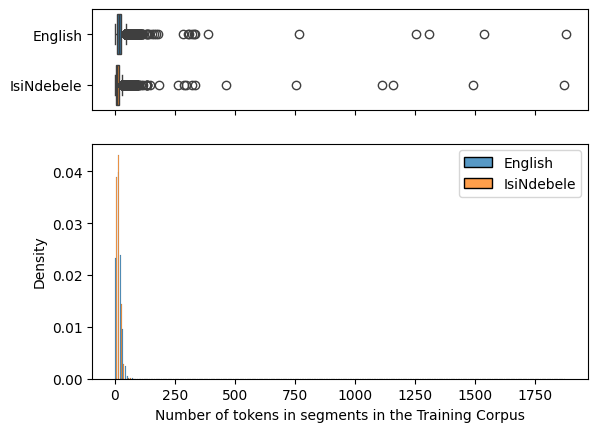

In [ ]:
# visualise length of segments in parallel corpus
fig, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.3, .7)})
sns.boxplot(df_train_sent_len.iloc[:, [0,1]], orient="h", ax=ax_box)
sns.histplot(df_train_sent_len.iloc[:, [0,1]],
             binwidth=10,
             stat='density',
             multiple='dodge',
             shrink=0.7,
             legend=True,
             common_norm=False,
             ax=ax_hist)

# add labels to plots
ax_hist.set_xlabel("Number of tokens in segments in the Training Corpus")
ax_hist.set_ylabel("Density")

# display plot
plt.show()

In [ ]:
# outliers on the source side of the training set
q1 = df_train_sent_len.iloc[:, 0].quantile(0.25)
q3 = df_train_sent_len.iloc[:, 0].quantile(0.75)
iqr =  q3 - q1
lower_source_outliers = q1 - (3 * iqr)
upper_source_outliers = q3 + (3 * iqr)
print(f"The outliers upper and lower bounds for the source side of training corpus: ({lower_source_outliers}, {upper_source_outliers})")

# outliers of the target side
q1 = df_train_sent_len.iloc[:, 1].quantile(0.25)
q3 = df_train_sent_len.iloc[:, 1].quantile(0.75)
iqr =  q3 - q1
lower_target_outliers = q1 - (3 * iqr)
upper_target_outliers = q3 + (3 * iqr)
print(f"The outliers upper and lower bounds for the target side of training corpus: ({lower_target_outliers}, {upper_target_outliers})")

The outliers upper and lower bounds for the source side of training corpus: (-31.0, 67.0)
The outliers upper and lower bounds for the target side of training corpus: (-22.0, 48.0)


In [ ]:
data_table.DataTable(df_train[df_train_sent_len[source_name] > 70], include_index=True, num_rows_per_page=20)

,English,IsiNdebele
704,2 . 8 Cabinet approved the submission of the S...,2 . 8 . IKhabinethi iphasise ukwethulwa kombik...
730,SECTION 2 : INTRODUCTION . . . . . . . . . . ....,ISIGABA 2 : ukwethula amalimi . . . . . . . . ...
1391,6 . This resolution will be signed by . . . . ...,6 . Isiqunto lesi sizokutlikitlwa malunga ali ...
1709,Link the language structure with functional us...,Hlobanisa isakhiwo selimi nokusetjenziswa kwel...
1961,Sports facilities for all . . . . . . . . . . ...,Iinkghonakalisi zezemidlalo zabo boke . . . . ...
...,...,...
90517,GENERAL To the maximum extent permitted by law...,MAZOMBE Esikhathini esiphezulu esivunyelwe mth...
90551,Ward councillor : . . . . . . . . . . . . . . ...,USomkhandlu wewadi . . . . . . . . . . . . . ....
90623,"Chronological / sequential order : first , sec...","Isigaba esikhethiweko : ngombono wami , ikolel..."
90949,Which season do you like best ? _ _ _ _ _ _ _ ...,Ngisiphi isikhathi somnyaka osithanda khulu ? ...


In [ ]:
data_table.DataTable(df_train[df_train_sent_len[target_name] > 50], include_index=True, num_rows_per_page=20)

,English,IsiNdebele
730,SECTION 2 : INTRODUCTION . . . . . . . . . . ....,ISIGABA 2 : ukwethula amalimi . . . . . . . . ...
1391,6 . This resolution will be signed by . . . . ...,6 . Isiqunto lesi sizokutlikitlwa malunga ali ...
1709,Link the language structure with functional us...,Hlobanisa isakhiwo selimi nokusetjenziswa kwel...
1961,Sports facilities for all . . . . . . . . . . ...,Iinkghonakalisi zezemidlalo zabo boke . . . . ...
2105,policy principles . . . . . . . . . . . . . . ...,3 . imigomo yomthethokambiso . . . . . . . . ....
...,...,...
90551,Ward councillor : . . . . . . . . . . . . . . ...,USomkhandlu wewadi . . . . . . . . . . . . . ....
90623,"Chronological / sequential order : first , sec...","Isigaba esikhethiweko : ngombono wami , ikolel..."
90695,Language learning in the Further Education and...,Ukufundwa kwelimi kuFundo neBandulo eThuthukak...
90949,Which season do you like best ? _ _ _ _ _ _ _ ...,Ngisiphi isikhathi somnyaka osithanda khulu ? ...


In [ ]:
# outliers on the source side of the validation set
q1 = df_val_sent_len.iloc[:, 0].quantile(0.25)
q3 = df_val_sent_len.iloc[:, 0].quantile(0.75)
iqr =  q3 - q1
lower_source_outliers = q1 - (3 * iqr)
upper_source_outliers = q3 + (3 * iqr)
print(f"The outliers upper and lower bounds for the source side of the validation corpus: ({lower_source_outliers}, {upper_source_outliers})")

# outliers of the target side
q1 = df_val_sent_len.iloc[:, 1].quantile(0.25)
q3 = df_val_sent_len.iloc[:, 1].quantile(0.75)
iqr =  q3 - q1
lower_target_outliers = q1 - (3 * iqr)
upper_target_outliers = q3 + (3 * iqr)
print(f"The outliers upper and lower bounds for the target side of the validation corpus: ({lower_target_outliers}, {upper_target_outliers})")

The outliers upper and lower bounds for the source side of the validation corpus: (-28.0, 63.0)
The outliers upper and lower bounds for the target side of the validation corpus: (-22.0, 48.0)


In [ ]:
# dropping segment pairs in training corpus
source_max_length = 70
target_max_length = 50

source_min_length = 1
target_min_length = 1

drop_index = []

for i in range(len(df_train_sent_len)):
  if df_train_sent_len.iloc[i,0] < source_min_length:
    drop_index.append(i)
  if df_train_sent_len.iloc[i,0] > source_max_length:
    drop_index.append(i)

  if df_train_sent_len.iloc[i,1] < target_min_length:
    drop_index.append(i)
  if df_train_sent_len.iloc[i,1] > target_max_length:
    drop_index.append(i)

drop_index = list(set(drop_index))
df_train.drop(drop_index, axis=0, inplace=True)
df_train_sent_len.drop(drop_index, axis=0, inplace=True)

In [ ]:
# resetting index in dataframes after dropping segment pairs
df_train.reset_index(drop=True, inplace=True)
df_train_sent_len.reset_index(drop=True, inplace=True)

In [ ]:
print("Summary for Training Corpus:")
print(df_train_sent_len.describe())

Summary for Training Corpus:
            English    IsiNdebele
count  91136.000000  91136.000000
mean      18.399260     13.755596
std       10.236546      7.730241
min        1.000000      1.000000
25%       11.000000      8.000000
50%       17.000000     12.000000
75%       24.000000     18.000000
max       70.000000     50.000000


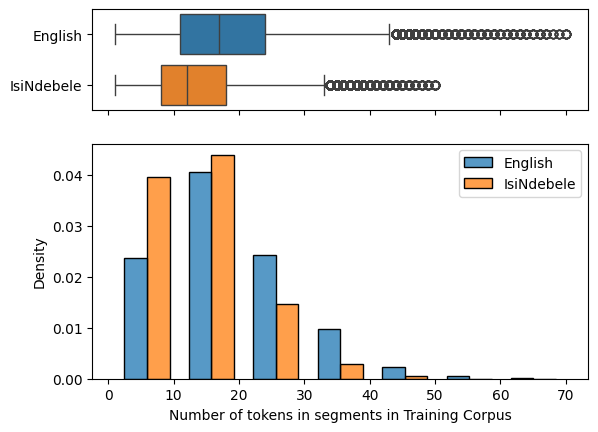

In [ ]:
# visualise data!
fig, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.3, .7)})
sns.boxplot(df_train_sent_len, orient="h", ax=ax_box)
sns.histplot(df_train_sent_len,
             binwidth=10,
             stat='density',
             multiple='dodge',
             shrink=0.7,
             legend=True,
             common_norm=False,
             ax=ax_hist)

# add labels to plots
ax_hist.set_xlabel("Number of tokens in segments in Training Corpus")
ax_hist.set_ylabel("Density")

# display plot
plt.show()

In [ ]:
# dropping segment pairs in validation corpus
source_max_length = 70
target_max_length = 50

source_min_length = 1
target_min_length = 1

drop_index = []

for i in range(len(df_val_sent_len)):
  if df_val_sent_len.iloc[i,0] < source_min_length:
    drop_index.append(i)
  if df_val_sent_len.iloc[i,0] > source_max_length:
    drop_index.append(i)

  if df_val_sent_len.iloc[i,1] < target_min_length:
    drop_index.append(i)
  if df_val_sent_len.iloc[i,1] > target_max_length:
    drop_index.append(i)

drop_index = list(set(drop_index))
df_val.drop(drop_index, axis=0, inplace=True)
df_val_sent_len.drop(drop_index, axis=0, inplace=True)

In [ ]:
# resetting index in dataframes after dropping segment pairs
df_val.reset_index(drop=True, inplace=True)
df_val_sent_len.reset_index(drop=True, inplace=True)

### Removing segment pairs with significant source to target ratio w.r.t length of segments in a pair

In [ ]:
# add a column to dataframe: length of source segment/length of target segment
df_train_sent_len = df_train_sent_len.assign(ratio = df_train_sent_len[source_name]/df_train_sent_len[target_name])
print("Summary for Training Corpus:")
print(df_train_sent_len.describe())

df_val_sent_len = df_val_sent_len.assign(ratio = df_val_sent_len[source_name]/df_val_sent_len[target_name])
print("\nSummary for Validation Corpus:")
print(df_val_sent_len.describe())

Summary for Training Corpus:
            English    IsiNdebele         ratio
count  91136.000000  91136.000000  91136.000000
mean      18.399260     13.755596      1.371413
std       10.236546      7.730241      0.430558
min        1.000000      1.000000      0.047619
25%       11.000000      8.000000      1.166667
50%       17.000000     12.000000      1.333333
75%       24.000000     18.000000      1.523810
max       70.000000     50.000000     41.000000

Summary for Validation Corpus:
            English    IsiNdebele         ratio
count  24153.000000  24153.000000  24153.000000
mean      18.130336     13.567342      1.367271
std       10.423096      7.826742      0.440472
min        1.000000      1.000000      0.115385
25%       10.000000      8.000000      1.153846
50%       17.000000     12.000000      1.333333
75%       24.000000     18.000000      1.523810
max       70.000000     50.000000     28.000000


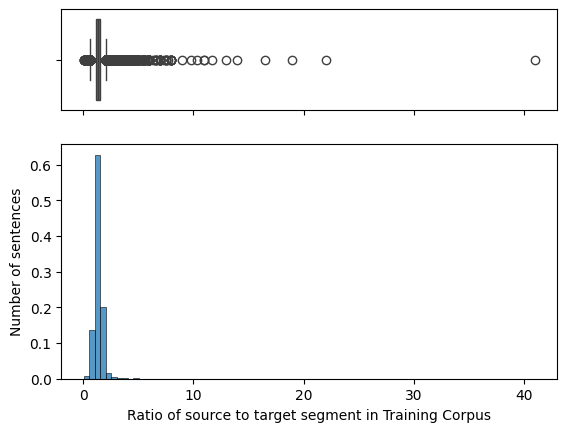

In [ ]:
# visualising ratio of source to target segments pairs
fig, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.3, .7)})
sns.boxplot(df_train_sent_len.iloc[:, 2], orient="h", ax=ax_box)
sns.histplot(df_train_sent_len.iloc[:, 2],
             binwidth=0.5,
             stat='proportion',
             ax=ax_hist)

# add labels to plots
ax_hist.set_xlabel("Ratio of source to target segment in Training Corpus")
ax_hist.set_ylabel("Number of sentences")

# display plot
plt.show()

In [ ]:
# finding outlier segment pairs in the training corpus
q1 = df_train_sent_len.iloc[:, 2].quantile(0.25)
q3 = df_train_sent_len.iloc[:, 2].quantile(0.75)
iqr =  q3 - q1
lower_outliers = q1 - (1.5 * iqr)
upper_outliers = q3 + (1.5 * iqr)

print(f"The outliers upper and lower bounds of the training corpus: ({lower_outliers}, {upper_outliers})")

The outliers upper and lower bounds of the training corpus: (0.6309523809523813, 2.0595238095238093)


In [ ]:
# finding outlier segment pairs in the validation corpus
q1 = df_val_sent_len.iloc[:, 2].quantile(0.25)
q3 = df_val_sent_len.iloc[:, 2].quantile(0.75)
iqr =  q3 - q1
lower_outliers = q1 - (1.5 * iqr)
upper_outliers = q3 + (1.5 * iqr)

print(f"The outliers upper and lower bounds of the validation corpus: ({lower_outliers}, {upper_outliers})")

The outliers upper and lower bounds of the validation corpus: (0.5989010989010988, 2.0787545787545785)


In [ ]:
# which segment pairs in the training corpus to drop?
max_ratio = 3
min_ratio = 3/5

drop_index = []
for i in range(len(df_train_sent_len)):
  if df_train_sent_len.iloc[i,2] < min_ratio:
    drop_index.append(i)
  if df_train_sent_len.iloc[i,2] > max_ratio:
    drop_index.append(i)

drop_index = list(set(drop_index))

In [ ]:
# visualising segment pairs that have been dropped
data_table.DataTable(df_train.iloc[drop_index,:], include_index=True, num_rows_per_page=20)

,English,IsiNdebele
73730,Given that school governing bodies have the po...,IKomitjhini yamaLungelo ye-CRL kufanele iziban...
24580,The changes must be recorded on Amended Foundi...,Amatjhuguluko lawo kumele arekhodwe esiTatimen...
24593,[ Item 9 deleted by s . 5 of the Constitution ...,[ ITjheduli 6B eyayibizwa ngeTjheduli 6A ngaph...
81939,Form RF1,IForomo RF1 elilethwa ngeduplikheyidi
8215,Homogeneous production,Ukukhiqizwa / ukuvezwa komhlobo munye
...,...,...
57326,"Children's Amendment Bill , 2015 ( section 75 ...",UmThethomlingwa womNyaka wee-2015 oTjhugulula ...
8176,"Predicate and object ,","iNyuvesi yeSewula Afrika , umuthi omkhulu otjh..."
81909,word bank - a store or file of new words,ibhanga yamagama - ibulungelo nofana ifayili y...
32759,Only registered importers and exporters can im...,Bathengi bangaphandle nabathengiseli bangaphan...


In [ ]:
# dropping segment pairs in training corpus
df_train.drop(drop_index, axis=0, inplace=True)
df_train_sent_len.drop(drop_index, axis=0, inplace=True)
print(f"The number of segment pairs left in the training corpus: {len(df_train)}")

# resetting index in dataframe after dropping segment pairs
df_train.reset_index(drop=True, inplace=True)
df_train_sent_len.reset_index(drop=True, inplace=True)

The number of segment pairs left in the training corpus: 89783


In [ ]:
# dropping segment pairs in validation corpus
drop_index = []
for i in range(len(df_val_sent_len)):
  if df_val_sent_len.iloc[i,2] < min_ratio:
    drop_index.append(i)
  if df_val_sent_len.iloc[i,2] > max_ratio:
    drop_index.append(i)

drop_index = list(set(drop_index))

df_val.drop(drop_index, axis=0, inplace=True)
df_val_sent_len.drop(drop_index, axis=0, inplace=True)
print(f"The number of segment pairs left in the validation corpus: {len(df_val)}")

# resetting index in dataframe after dropping segment pairs
df_val.reset_index(drop=True, inplace=True)
df_val_sent_len.reset_index(drop=True, inplace=True)

The number of segment pairs left in the validation corpus: 23761


## Token Count

### Comparing source token count between training, validation and test sets:

In [ ]:
# create a new dataframe: length of segment on each side of the parallel corpora
df_segment_len = pd.DataFrame({f"{source_name} in Train": df_train[source_name].str.split().apply(len),
                            f"{source_name} in Validation": df_val[source_name].str.split().apply(len),
                            f"{source_name} in Test": df_test[source_name].str.split().apply(len)})

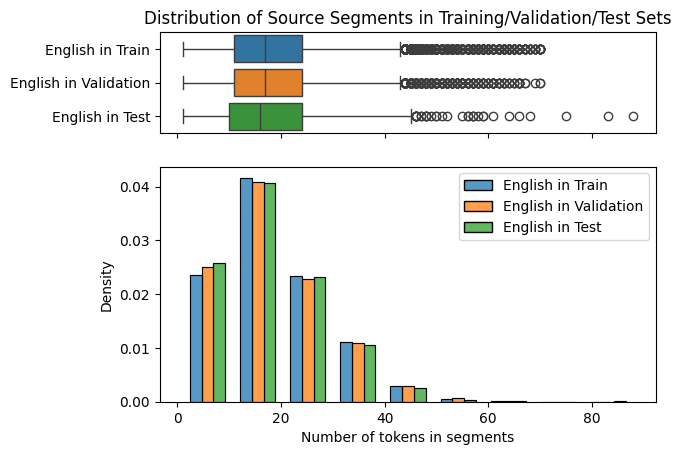

In [ ]:
# visualise data!
fig, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.3, .7)})
sns.boxplot(df_segment_len, orient="h", ax=ax_box)
sns.histplot(df_segment_len,
             binwidth=10,
             stat='density',
             multiple='dodge',
             shrink=0.7,
             legend=True,
             common_norm=False,
             ax=ax_hist)

# add labels to plots
ax_hist.set_xlabel("Number of tokens in segments")
ax_box.set_title("Distribution of Source Segments in Training/Validation/Test Sets")

# display plot
plt.show()

### Token count (incl. words, numbers and punctuation):

In [ ]:
df_tokens_count = df_train.copy(deep=True)

# create new dataframes: length of words on each side of the parallel corpus
source_tokens_count = defaultdict(int)
target_tokens_count = defaultdict(int)

# counting number of tokens
for segment in df_tokens_count[source_name]:
  for word in segment.split():
    source_tokens_count[word] += 1

for segment in df_tokens_count[target_name]:
  for word in segment.split():
    target_tokens_count[word] += 1

print(f"Number of unique tokens (incl. words, numbers and punctuation) on the {source_name} side is: {len(source_tokens_count)}.")
print(f"Number of tokens (incl. words, numbers and punctuation) on the {source_name} side is: {sum(source_tokens_count.values())}.")
print()
print(f"Number of unique tokens (incl. words, numbers and punctuation) on the {target_name} side is: {len(target_tokens_count)}.")
print(f"Number of tokens (incl. words, numbers and punctuation) on the {target_name} side is: {sum(target_tokens_count.values())}.")

Number of unique tokens (incl. words, numbers and punctuation) on the English side is: 37709.
Number of tokens (incl. words, numbers and punctuation) on the English side is: 1663670.

Number of unique tokens (incl. words, numbers and punctuation) on the IsiNdebele side is: 164887.
Number of tokens (incl. words, numbers and punctuation) on the IsiNdebele side is: 1241715.


### Token count (incl. words and numbers):

In [ ]:
# create new dataframes: length of words on each side of the parallel corpus
source_tokens_count2 = source_tokens_count.copy()
target_tokens_count2 = target_tokens_count.copy()

# counting number of tokens
for token in source_tokens_count:
  if token in punc:
    source_tokens_count2.pop(token)

for token in target_tokens_count:
  if token in punc:
    target_tokens_count2.pop(token)

print(f"Number of unique tokens (incl. words and numbers) on the {source_name} side is: {len(source_tokens_count2)}.")
print(f"Number of tokens (incl. words and numbers) on the {source_name} side is: {sum(source_tokens_count2.values())}.")
print()
print(f"Number of unique tokens (incl. words and numbers) on the {target_name} side is: {len(target_tokens_count2)}.")
print(f"Number of tokens (incl. words and numbers) on the {target_name} side is: {sum(target_tokens_count2.values())}.")

Number of unique tokens (incl. words and numbers) on the English side is: 37688.
Number of tokens (incl. words and numbers) on the English side is: 1498758.

Number of unique tokens (incl. words and numbers) on the IsiNdebele side is: 164867.
Number of tokens (incl. words and numbers) on the IsiNdebele side is: 1077628.


### Token count (i.e., just words):

In [ ]:
# create new dataframes: length of words on each side of the parallel corpus
source_tokens_count3 = source_tokens_count2.copy()
target_tokens_count3 = target_tokens_count2.copy()

# counting number of tokens
for token in source_tokens_count2:
  if token.isdigit() == True:
    source_tokens_count3.pop(token)

for token in target_tokens_count2:
  if token.isdigit() == True:
    target_tokens_count3.pop(token)

print(f"Number of unique tokens (i.e. just words) on the {source_name} side is: {len(source_tokens_count3)}.")
print(f"Number of tokens (i.e. just words) on the {source_name} side is: {sum(source_tokens_count3.values())}.")
print()
print(f"Number of unique tokens (i.e. just words) on the {target_name} side is: {len(target_tokens_count3)}.")
print(f"Number of tokens (i.e. just words) on the {target_name} side is: {sum(target_tokens_count3.values())}.")

Number of unique tokens (i.e. just words) on the English side is: 36905.
Number of tokens (i.e. just words) on the English side is: 1479878.

Number of unique tokens (i.e. just words) on the IsiNdebele side is: 164218.
Number of tokens (i.e. just words) on the IsiNdebele side is: 1065364.


### Comparing length of words between source and target:

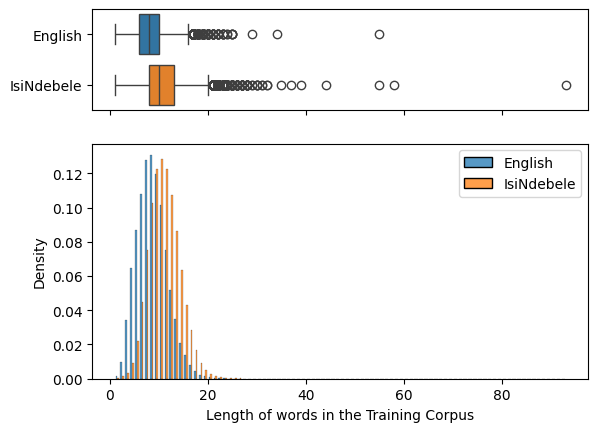

In [ ]:
# create a new dataframe: length of segment on each side of the parallel corpora
source_word_len = pd.DataFrame({word: list(source_tokens_count3.keys())})
source_word_len = source_word_len.assign(source_name = source_word_len[word].str.len())
source_word_len = source_word_len.rename(columns={'source_name': source_name})
target_word_len = pd.DataFrame({word: list(target_tokens_count3.keys())})
target_word_len = target_word_len.assign(target_name = target_word_len[word].str.len())
target_word_len = target_word_len.rename(columns={'target_name': target_name})

# visualise!
fig, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.3, .7)})
sns.boxplot([source_word_len.iloc[:, 1], target_word_len.iloc[:, 1]], orient="h", ax=ax_box)
sns.histplot([source_word_len.iloc[:, 1], target_word_len.iloc[:, 1]],
             binwidth=1,
             stat='density',
             multiple='dodge',
             shrink=0.7,
             common_norm=False,
             legend=True,
             ax=ax_hist)

# add labels to plots
ax_hist.set_xlabel("Length of words in the Training Corpus")
ax_hist.set_ylabel("Density")

# display plot
plt.show()

## Convert Datasets to Binary Files

For tokenization and model building...

In [ ]:
with open(f'{main_path}/cleaned-data/train.{source_code}', 'w') as f:
  for segment in df_train[source_name]:
    f.write(segment + '\n')

with open(f'{main_path}/cleaned-data/train.{target_code}', 'w') as f:
  for segment in df_train[target_name]:
    f.write(segment + '\n')

with open(f'{main_path}/cleaned-data/val.{source_code}', 'w') as f:
  for segment in df_val[source_name]:
    f.write(segment + '\n')

with open(f'{main_path}/cleaned-data/val.{target_code}', 'w') as f:
  for segment in df_val[target_name]:
    f.write(segment + '\n')

with open(f'{main_path}/cleaned-data/test.{source_code}', 'w') as f:
  for segment in df_test[source_name]:
    f.write(segment + '\n')

with open(f'{main_path}/cleaned-data/test.{target_code}', 'w') as f:
  for segment in df_test[target_name]:
    f.write(segment + '\n')